In [1]:
import yaml
import model
import mnist1d
import numpy as np
import visualizations as vis
from torchvision import datasets, transforms

np.random.seed(42)

##### **How to use this notebook**:

In the configuration you can set:
- Dataset (MNIST1D, MNIST, or CIFAR10)
- Hidden dimensions (number of hidden units per layer; depth is set to 3)
- Number of epochs
- What permutatations to apply (shuffled labels, shuffled pixel, random pixel, gaussian noise, original data + gaussian noise)  

**Some tips**:

- MNIST1D trains quickly but isn't as visually intuitive
- MNIST and CIFAR10 offer clearer visualization, but take longer to train
- When using MNIST or CIFAR10, choose fewer permutations to get results in a reasonable time
- You get good results with:
    - 15 epochs on MNIST1D (unless you use shuffled labels or random pixel, then 30)
    - 25 epochs on MNIST (unless you use shuffled labels or random pixel, then at least 40) 

### Load configuration

In [2]:
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)

name_dataset = config['dataset']
hidden_dimensions = config['model'].get('hidden_dimensions')
output_dimensions = 10
epochs = config['training'].get('epochs')

### Load data

- load the data either from the repository or use standard datasets hardcoded into the torchvision library
- set the input dimenstion according to the dataset
- convert the data to the type numpy.ndarray so that all the datasets can later be permuted by the same functions
- for MNIST and CIFAR10: reconstruct the pictures for easier visualization

In [3]:
# Loads the data (specified in the configuration)
if name_dataset == "MNIST1D":
    input_dimensions = 40
        
    args = mnist1d.get_dataset_args()
    data = mnist1d.get_dataset(args, path='./data/mnist1d_data.pkl')

    # All the data is already of the type numpy.ndarray
    x_train = data['x']
    y_train = data['y']
    x_test = data['x_test']
    y_test = data['y_test']
        
elif name_dataset == "MNIST":
    input_dimensions = 784

    train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
    test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

    # converts all the data to the type numpy.ndarray
    x_train = train.data.numpy()
    y_train = train.targets.numpy()
    x_test = test.data.numpy()
    y_test = test.targets.numpy()

    x_train = x_train.reshape(-1, 28*28) / 255.0
    x_test = x_test.reshape(-1, 28*28) / 255.0

elif name_dataset == "CIFAR10":
    input_dimensions = 3072
    train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
    test = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

    # converts all the data to the type numpy.ndarray
    x_train = train.data
    y_train = np.array(train.targets)
    x_test = test.data
    y_test = np.array(test.targets)

    x_train = x_train.reshape(-1, 32*32*3) / 255.0
    x_test = x_test.reshape(-1, 32*32*3) / 255.0

else:
    raise ValueError("Invalid dataset name")

### Permute data

**Generate the permutations** (all specified in the configuration) and store them as seperate datasets.

All possible permutations:

- Shuffled label:
    - shuffles all the instances in the training label dataset
    - assigns a random label to every example in the training dataset
    - doesn't change the distribution since no new labels are generated

  
- Shuffled pixel:
    - shuffles all the pixel in every example in the training dataset
    - distribution within the example remains the same, only changes order of pixels
    - the labels also stay the same

- Random pixel:
    - assigns random pixels
    - creates a completely new distribution
    - the labels stay the same
    - examples only consist of noise
    - destroys any underlying structure

- Gaussian noise:
    - assigns new pixels based on the gaussian distribution of the original 
    - statistically keeps the distribution intact
    - the labels stay the same

- Original data + gaussian noise:
    - keeps the orinal examples but adds noise on top
    - the labels stay the same
    - keeps the underlying structure somewhat intact

In [4]:
# Permutes the data and stores them as seperate datasets (all permutations are specified in the configuration)
datasets = [('true labels', x_train, y_train)]

if config['permutations'].get('shuffled_label') == 'y':
    # Create dataset with shuffle the labels
    y_train_shuffled = np.random.permutation(y_train)
    datasets.append(('shuffled labels', x_train, y_train_shuffled))
elif config['permutations'].get('shuffled_label') != 'n':
    raise ValueError("Invalid input")


if config['permutations'].get('shuffled_pixel') == 'y':
    # Create dataset with shuffled the pixels for each picture
    x_shuffled = np.copy(x_train)
    for i in range(x_shuffled.shape[0]):
        np.random.shuffle(x_shuffled[i])
    datasets.append(('shuffled pixels', x_shuffled, y_train))
elif config['permutations'].get('shuffled_pixel') != 'n':
    raise ValueError("Invalid input")


if config['permutations'].get('random_pixel') == 'y':
    # Create dataset with random pixels
    x_random = np.random.rand(*x_train.shape)
    datasets.append(('random pixels', x_random, y_train))
elif config['permutations'].get('random_pixel') != 'n':
    raise ValueError("Invalid input")


if config['permutations'].get('gaussian_noise') == 'y':
    # Create dataset with gaussian noise
    gaussian_noise = np.random.normal(loc=np.mean(x_train), scale=np.std(x_train), size=x_train.shape)
    datasets.append(('gaussian noise', gaussian_noise, y_train)) 
elif config['permutations'].get('gaussian_noise') != 'n':
    raise ValueError("Invalid input")


if config['permutations'].get('original_data_plus_gaussian_noise') == 'y':
    #Create dataset with gaussian noise on top of the original data
    gaussian_noise = np.random.normal(loc=np.mean(x_train), scale=np.std(x_train), size=x_train.shape)
    x_train_noisy = x_train + gaussian_noise
    datasets.append(('true data + gaussian noise', x_train_noisy, y_train))
elif config['permutations'].get('original_data_plus_gaussian_noise') != 'n':
    raise ValueError("Invalid input")

### Visualize Data

**Visualize the training data** (original and all the permutations) to get a more intuitive understanding on how the permutatios differ from the original.

Works especially well for MNIST and CIFAR10, not so much for MNIST1D

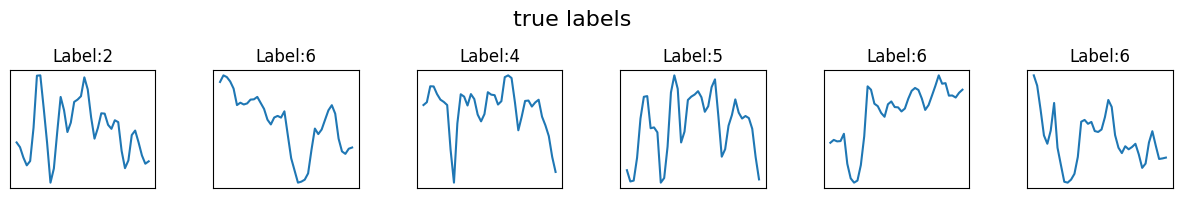

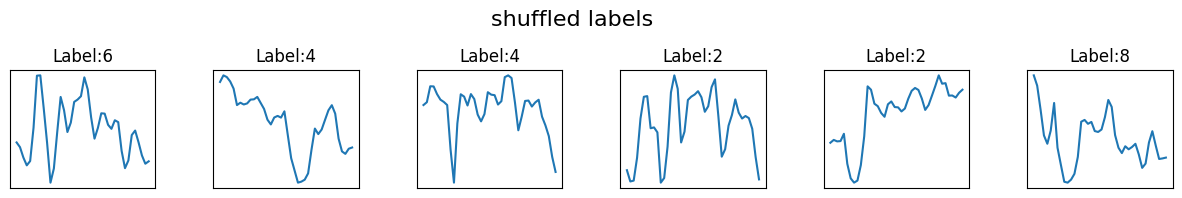

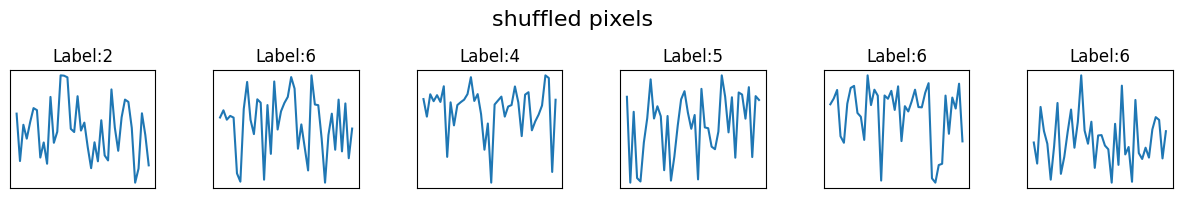

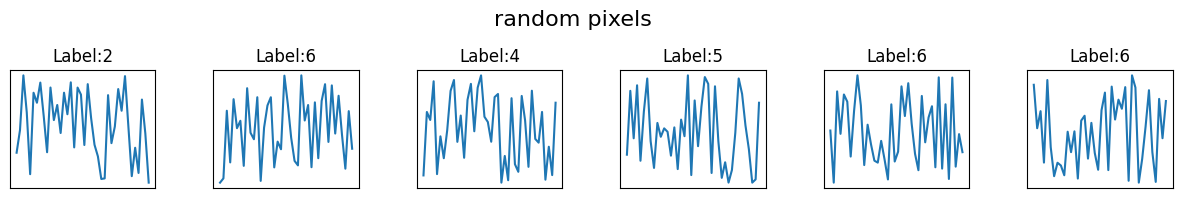

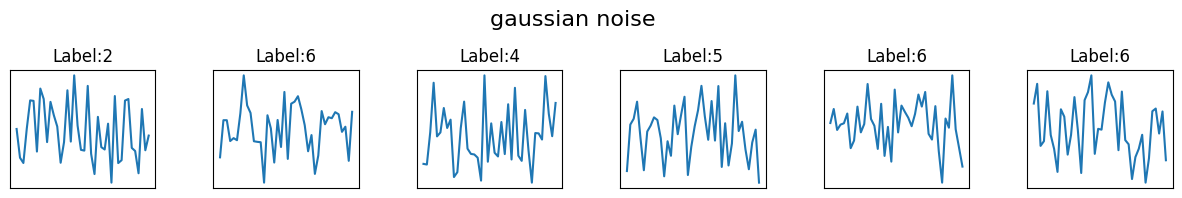

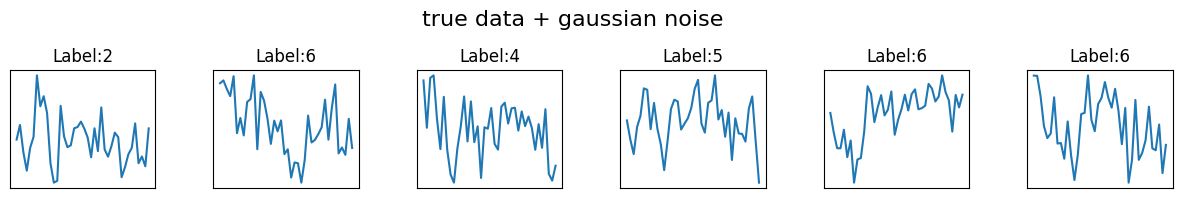

In [5]:
# Visualize data samples for each of the datasets (original and all the permutated datasets)
for x in datasets:
    vis.visualize_data(x[1], x[2], name_dataset, True, x[0])

### Run the training of the model

**Train seperate models** on all the datasets respectively and store for every training epoch:
- loss on training data
- loss on test data 
- accuracy on training data
- accuracy on test data 

In [6]:
# Lists to store training and test results
losses = []
accuracies = []

# Train model on each dataset and collect results
for x in datasets:
    loss_train, acc_train, loss_test, acc_test = model.train_model(input_dimensions, hidden_dimensions, output_dimensions, x[0], x[1], x[2], x_test, y_test, epochs)
    losses.append((f'{x[0]}', loss_train, loss_test))
    accuracies.append((f'{x[0]}', acc_train, acc_test))

'Dataset: true data + gaussian noise, Epoch 55: Train loss = 0.0008, Train accuracy = 1.0000, Test loss = 2.8361, Test accuracy = 0.3870'

### Visualize results

**Visualize the results of the training**  
Plot loss and accuracy on both training and test data.

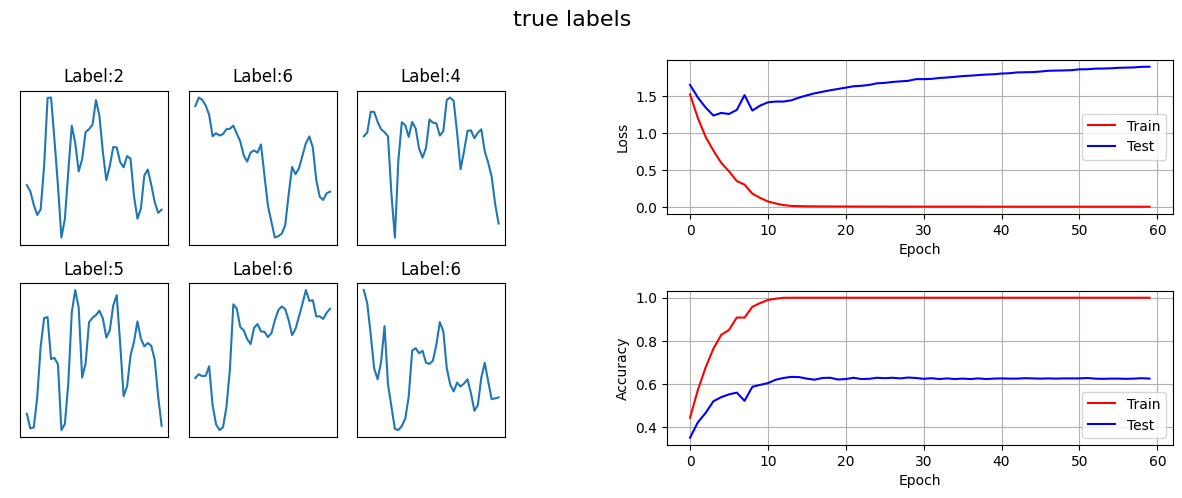

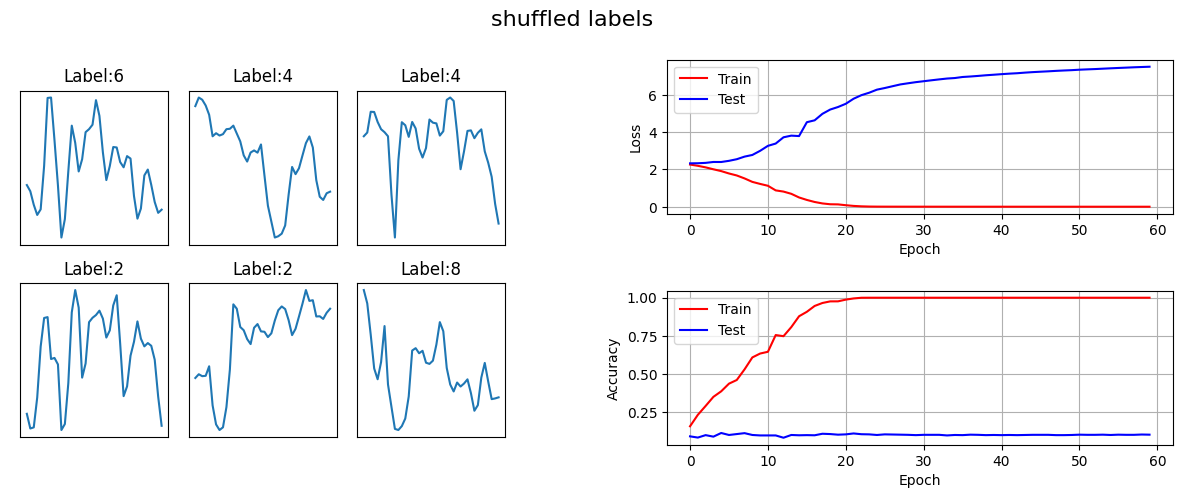

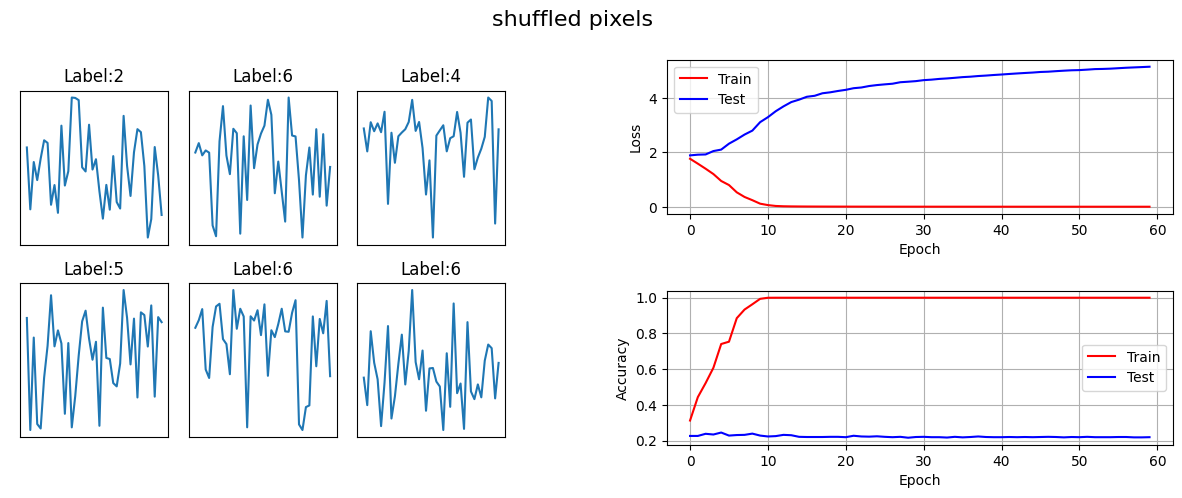

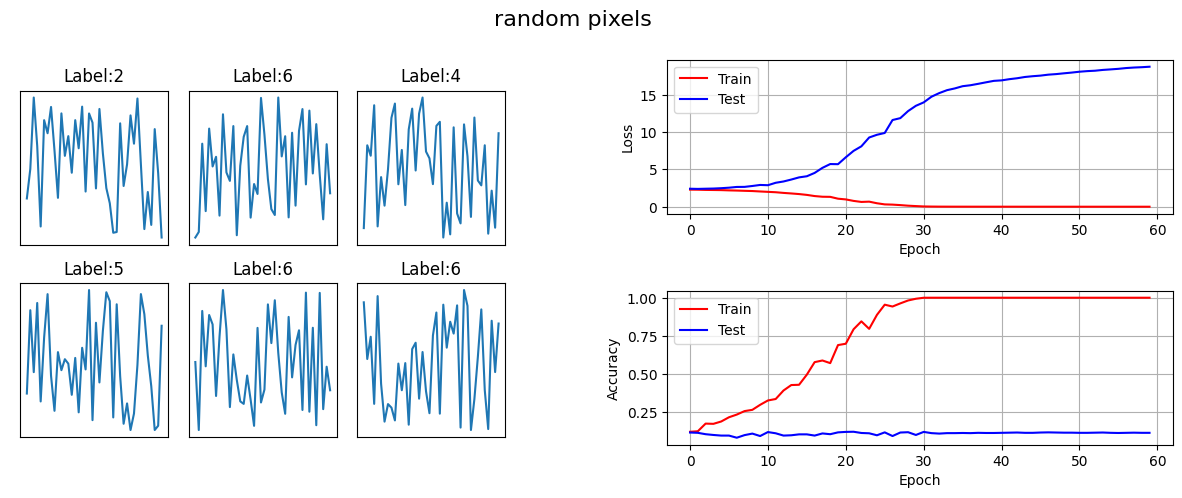

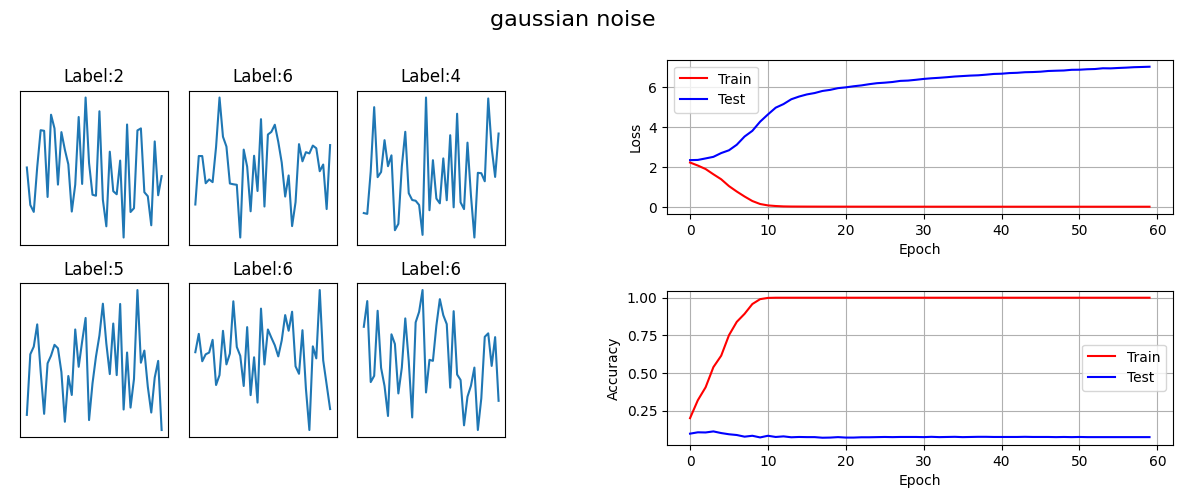

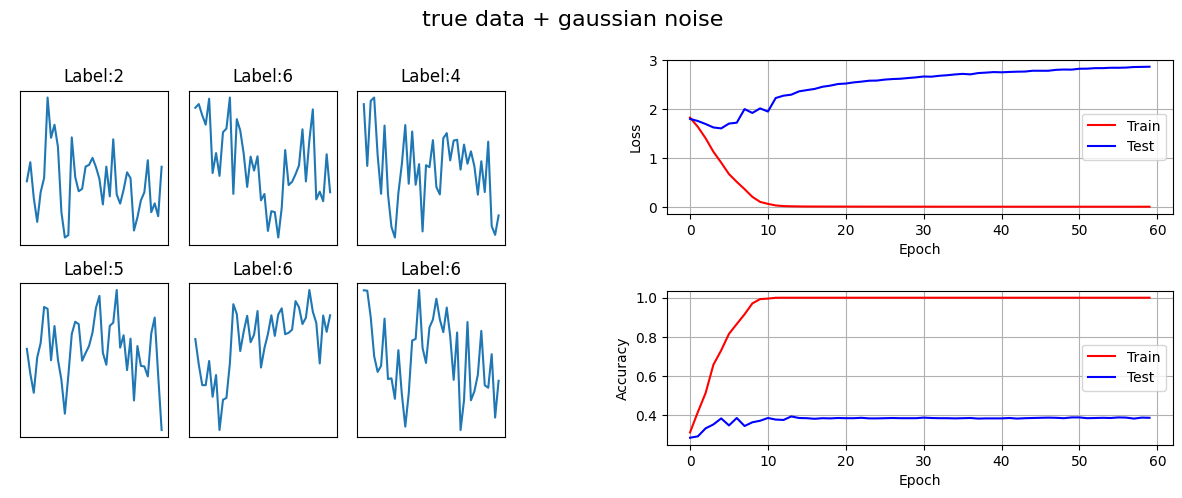

In [7]:
# Visualize summary for each dataset
for x in range(len(datasets)):
    vis.summary(datasets[x][0], datasets[x][1], datasets[x][2], name_dataset, losses[x][1], accuracies[x][1], losses[x][2], accuracies[x][2])

What you should see:  

- Loss on training decreases for all the models
- Accuracy on training increases for all the models
- For the original data: loss and accuracy also improve on test data
- For the rest: loss and accuracy improve only slightly or not at all for test data

What this means: 
- Permuting the data and removing underlying structures hinders generalization
- BUT the model still learns some function and can therefore fit the training data well after sufficiently many itterations

**Compare the different variants to each other**  
Plot all the losses in one figure and all the accuracies in another

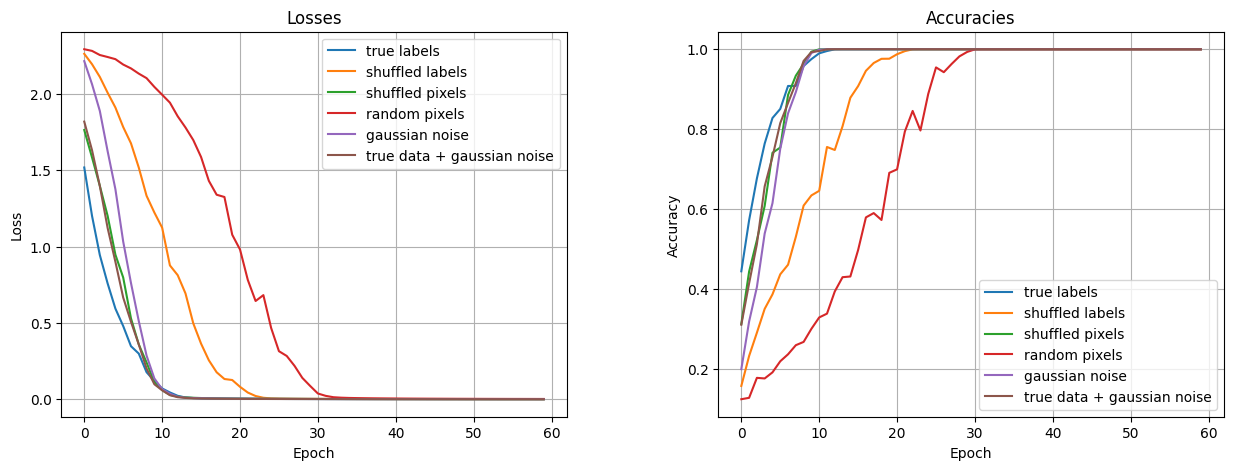

In [8]:
# Create summary statistics plots
vis.summary_statistics(losses, accuracies)

What you should see:

- The model training on the original data trains the fastest
- Nontheless the other models still improve but do take longer